# Data_preparation

In [1]:
import json
from pathlib import Path
from collections import Counter
from google.colab import drive
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, vocab, Vectors
from torch.nn.utils.rnn import pack_padded_sequence
from pprint import pprint
from tqdm import tqdm
from collections import Counter
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED) # Best effort to be reproducible. If there are nondeterministic operations like some cnn kernels you have different results even with the same seed.
torch.backends.cudnn.deterministic = True  # Uses deterministic operations when possible, otherwise raises an error

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
drive.mount('/content/drive')
train_OG_path = Path('/content/drive/My Drive/HM1_B-1965733/data/train.jsonl') #percorso_train
test_path = Path('/content/drive/My Drive/HM1_B-1965733/data/test.jsonl') #percorso test


Mounted at /content/drive


In [4]:
def count_lines_and_label_distribution(path: Path) -> int:
    with open(path, 'r') as f:
        lines = f.readlines()
    data = [json.loads(line) for line in lines]
    df = pd.DataFrame(data)
    num_lines = len(df)
    label_distribution = df['label'].value_counts(normalize=True)
    print(f"Number of samples: {num_lines}")
    print("Label distribution:")
    print(label_distribution)

count_lines_and_label_distribution(train_OG_path)
count_lines_and_label_distribution(test_path)

Number of samples: 4409
Label distribution:
label
0    0.535722
2    0.355863
1    0.108415
Name: proportion, dtype: float64
Number of samples: 1000
Label distribution:
label
0    0.500
1    0.324
2    0.176
Name: proportion, dtype: float64


In [8]:
def create_validation_set(path: Path, test_size: float) -> None:
    with open(path, 'r') as f:
        lines = f.readlines()
    data = [json.loads(line) for line in lines]
    df = pd.DataFrame(data)

    # Stratified split to maintain label distribution
    train_df, val_df = train_test_split(df, test_size=test_size, stratify=df['label'])

    print(f"Train set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")

    # Save the new train and validation sets
    train_df.to_json('/content/drive/My Drive/HM1_B-1965733/data/train_split.jsonl', orient='records', lines=True)
    val_df.to_json('/content/drive/My Drive/HM1_B-1965733/data/val_split.jsonl', orient='records', lines=True)

create_validation_set('/content/drive/My Drive/HM1_B-1965733/data/train.jsonl', test_size=0.15)
valid_path=Path('/content/drive/My Drive/HM1_B-1965733/data/val_split.jsonl')
train_path=Path('/content/drive/My Drive//HM1_B-1965733/data/train_split.jsonl')


Train set size: 3747
Validation set size: 662


In [9]:
def print_label_distribution(df: pd.DataFrame) -> None:
    label_distribution = df['label'].value_counts(normalize=True)
    print("Label distribution:")
    print(label_distribution)

val_df = pd.read_json('/content/drive/My Drive/HM1_B-1965733/data/val_split.jsonl', lines=True)
print_label_distribution(val_df)


Label distribution:
label
0    0.536254
2    0.354985
1    0.108761
Name: proportion, dtype: float64


In [10]:
class SST2Dataset(Dataset):
    def __init__(
        self,
        input_file: Path,
        max_length: int = 1028,
        device: str = "cuda"
    ):
        # Get simple tokenizer
        tokenizer = get_tokenizer(None)

        # Save samples from input jsonl file
        self.samples = []
        with open(input_file, "r") as f:
            for line in f:
                sample = json.loads(line.strip())
                # the sample dictionary contains the following key: idx, text and label (integer)
                sample["tokens"] = tokenizer(sample["text"])
                self.samples.append(sample)

        # Initialize indexed data attribute but leave it None
        # Must be filled through the `.index(vocabulary, label_vocabulary)` method
        # each dictionary represents a sentence with two keys: "input_ids" and "label"
        self.indexed_data: list[dict] | None = None

        # Keep track of the maximum length to allow for a batch
        self.max_length = max_length
        # Save device
        self.device = torch.device(device)
        # Keep track of padding id
        self.padding_id: int | None = None

    def get_raw_element(self, idx: int) -> dict:
        """Utility function that gets the raw sample corresponding to `idx`."""
        return self.samples[idx]

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        if self.indexed_data is None:
            raise RuntimeError(
                "Trying to retrieve samples but dataset has not been indexed yet!"
                + " Be sure to call `.index()` on this object."
                + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
            )
        return self.indexed_data[idx]

    def get_vocabulary(
        self,
        pad_token: str = "<pad>",
        unk_token: str = "<unk>",
        extra_tokens: list[str] = []
    ) -> Vocab:
        """Builds a `torchtext.vocab.Vocab` object from data stored in this object."""
        # most_common() returns a list of (token, count) pairs, so we convert them back into dictionary
        vocab_counter = dict(Counter(token for sent in self.samples for token in sent["tokens"]).most_common())
        # We build the vocabulary through a dictionary like {token: frequency, ...}
        vocabulary = vocab(vocab_counter, min_freq=1, specials=[pad_token, unk_token, *extra_tokens])
        # vocabulary(list of tokens) returns a list of values, so get the only one
        vocabulary.set_default_index(vocabulary([unk_token])[0])
        return vocabulary

    def set_padding_id(self, value: int) -> None:
        self.padding_id = value

    def index(self, vocabulary: Vocab) -> None:
        """Builds `self.indexed_data` by converting raw samples to input_ids following `vocabulary`"""
        if self.indexed_data is not None:
            print("Dataset has already been indexed. Keeping old index...")
        else:
            indexed_data = []
            for sample in self.samples:
                # append the dictionary containing ids of the input tokens and label
                indexed_data.append({"input_ids": vocabulary(sample["tokens"]), "label": sample["label"]})
            self.indexed_data = indexed_data

    def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Batches together single elements of the dataset.
        This function:
        - converts each sentence made up of single input_ids to a padded tensor,
        - keeps track of the length of each sentence through `sequence_lengths`
        - builds a `labels` tensor storing the label for each sentence
        Args: raw_batch (list[dict]): a list of elements, as returned by the `__getitem__()` function.
        Returns: a tuple of three tensors, respectively `(sequence_lengths, padded_sequence, labels)`
        """
        if self.padding_id is None:
            raise RuntimeError("Padding value not set! Set it through .set_padding_id method.")

        # We need these sequence lengths to construct a `torch.nn.utils.rnn.PackedSequence` in the model
        sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype=torch.long)
        padded_sequence = pad_sequence(
            (
                torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device)
                for sample in raw_batch
            ),
            batch_first=True,
            padding_value=self.padding_id
        )
        labels = torch.tensor([sample["label"] for sample in raw_batch], device=self.device, dtype=torch.long)
        return sequence_lengths, padded_sequence, labels

# Model

In [11]:
class BiLSTMModel(torch.nn.Module):

    def __init__(
        self,
        vocabulary_length: int,
        hidden_dim: int,
        bilstm_layers: int,
        bilstm_dropout: float,
        num_classes: int,
        padding_id: int,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        # Prepare the device
        self.device = torch.device(device)

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_length,
            embedding_dim=hidden_dim,
            padding_idx=padding_id, # avoid updating the gradient of padding entries
            device=self.device
        )

        # BiLSTM
        self.bilstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=bilstm_layers,
            batch_first=True,
            dropout=bilstm_dropout,
            bidirectional=True,
            device=self.device
        )

        # Projection layer
        self.projection = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=num_classes,
            device=device
        )

    def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # Get the different parts of the batch
        sequence_lengths, input_ids = batch

        # First we embed the input tokens
        embeds = self.embedding(input_ids) # [B, S, H]
        # where B is the batch size, S is the sequence length and H is the hidden dimension

        # Pack the sequence to avoid gradient descent on padding tokens.
        packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

        # Then we pass it to the BiLSTM
        # The first output of the BiLSTM tuple, packed_output, is of size B x S x 2H,
        # where B is the batch size, S is the sequence length and H is the hidden dimension
        # hidden_state is of size [2 * num_layers, B, H], where the 2 is because we are using BiLSTMs instead of LSTMs.
        # cell_state has size [2 * num_layers, B, C] where C is the cell dimension of the internal LSTMCell.
        packed_output, (hidden_state, cell_state) = self.bilstm(packed)

        # We take the last two hidden representations of the BiLSTM (the second-to-last layer's output is forward; last
        # layer's is backward) by concatenating forward and backward over dimension 1.
        # Both tensors have shapes of [B, H], so concatenating them along the second dimension (dim 1) results in a new
        # tensor of shape [B, 2 * H]
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)

        # Finally we project to the two final classes and return the logits of each class
        logits = self.projection(hidden) # [B, 2]
        return logits

# Training

In [12]:
class Trainer():

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_steps: int = 1_000,
        log_level: int = 2
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = nn.CrossEntropyLoss() # default loss used nearly everywhere in NLP
        self.log_steps = log_steps
        self.log_level = log_level

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> dict[str, list[float]]:
        """
        Args:
            train_dataloader: a DataLoader instance containing the training instances.
            valid_dataloader: a DataLoader instance used to evaluate learning progress.
            epochs: the number of times to iterate over train_dataset.
        Returns:
            avg_train_loss: the average training loss on train_dataset over epochs.
        """
        assert epochs >= 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0

        losses = {
            "train_losses": [],
            "valid_losses": [],
            "valid_acc": [],
        }

        for epoch in range(1, epochs + 1):
            if self.log_level > 0:
                print(' Epoch {:2d}'.format(epoch))

            epoch_loss = 0.0
            self.model.train()

            # for each batch
            for step, (sequence_lengths, inputs, labels) in enumerate(train_dataloader):
                self.optimizer.zero_grad()

                # We get the predicted logits from the model, with no need to perform any flattening
                # as both predictions and labels refer to the whole sentence.
                predictions = self.model((sequence_lengths, inputs))

                # The CrossEntropyLoss expects the predictions to be logits, i.e. non-softmaxed scores across
                # the number of classes, and the labels to be a simple tensor of labels.
                # Specifically, predictions needs to be of shape [B, C], where B is the batch size and C is the number of
                # classes, while labels must be of shape [B] where each element l_i should 0 <= l_i < C.
                # See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more information.
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.cpu().tolist()

                if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))

            avg_epoch_loss = epoch_loss / len(train_dataloader)

            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss, valid_acc, valid_f1, conf_matrix = self.evaluate(valid_dataloader)

            losses["train_losses"].append(avg_epoch_loss)
            losses["valid_losses"].append(valid_loss)
            losses["valid_acc"].append(valid_acc)

            if self.log_level > 0:
                print('  [E: {:2d}] val loss = {:0.4f}, val acc = {:0.4f}, val f1 = {:0.4f}'.format(epoch, valid_loss, valid_acc, valid_f1))

        if self.log_level > 0:
            print('... Done!')

        return losses


    def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        # logits [B, 2] are the logits outputted by the BiLSTM model's forward()
        # We take the argmax along the second dimension (dim=1), so we get a tensor of shape [B]
        # where each element is 0 if the 0-class had higher logit, 1 otherwise.
        predictions = torch.argmax(logits, dim=1)
        # We can then directly compare each prediction with the labels, as they are both tensors with shape [B].
        # The average of the boolean equality checks between the two is the accuracy of these predictions.
        # For example, if:
        #   predictions = [1, 0, 0, 1, 1]
        #   labels = [1, 0, 1, 1, 1]
        # The comparison is:
        #   (predictions == labels) => [1, 1, 0, 1, 1]
        # which averaged gives an accuracy of 4/5, i.e. 0.80.
        return torch.mean((predictions == labels).float()).tolist() # type: ignore



    def evaluate(self, valid_dataloader: DataLoader) -> tuple[float, float, float, np.ndarray]:
        """
        Args:    valid_dataloader: the DataLoader to use to evaluate the model.
        Returns: avg_valid_loss: the average validation loss over valid_dataloader.
        """
        valid_loss = 0.0
        valid_acc = 0.0
        all_predictions = []
        all_labels = []

        self.model.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                sequence_lengths, inputs, labels = batch

                logits = self.model((sequence_lengths, inputs))

                sample_loss = self.loss_function(logits, labels)
                valid_loss += sample_loss.tolist()
                sample_acc = self._compute_acc(logits, labels)
                valid_acc += sample_acc

                # Store predictions and labels
                predictions = torch.argmax(logits, dim=1)
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate F1 score
        valid_f1 = f1_score(all_labels, all_predictions, average='weighted')
        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_predictions)

        return valid_loss / len(valid_dataloader), valid_acc / len(valid_dataloader), valid_f1, conf_matrix

    def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args: x: a tensor of indices
        Returns:
            A tuple composed of:
            - the logits of each class, 0 and 1
            - the prediction for each sample in the batch
              0 if the sentiment of the sentence is negative, 1 if it is positive.
        """
        self.model.eval()
        with torch.no_grad():
            sequence_lengths, inputs = batch
            logits = self.model(sequence_lengths, inputs) # [B, 2]
            predictions = torch.argmax(logits, -1) # [B, 1] computed on the last dimension of the logits tensor
            return logits, predictions


In [13]:
pad_token, unk_token = "<pad>", "<unk>"

train_dataset = SST2Dataset(train_path, device=device)
valid_dataset = SST2Dataset(valid_path, device=device)
test_dataset = SST2Dataset(test_path, device=device)

vocabulary = train_dataset.get_vocabulary(pad_token=pad_token, unk_token=unk_token)
padding_id = vocabulary([pad_token])[0]

train_dataset.set_padding_id(padding_id)
test_dataset.set_padding_id(padding_id)
valid_dataset.set_padding_id(padding_id)

train_dataset.index(vocabulary)
valid_dataset.index(vocabulary)
test_dataset.index(vocabulary)

training_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=train_dataset._collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=train_dataset._collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=test_dataset._collate_fn)


In [ ]:
# Grid-search:

# hyperparameters to test
#hidden_dims = [64, 128]
#bilstm_layers = [2, 3]
#bilstm_dropouts = [0.3, 0.4]

#results = []
# Loop over the hyperparameters
#for hidden_dim in hidden_dims:
    #for layer in bilstm_layers:
        #for dropout in bilstm_dropouts:
            #classifier = BiLSTMModel(
                #vocabulary_length=len(vocabulary),
                #hidden_dim=hidden_dim,
                #bilstm_layers=layer,
                #bilstm_dropout=dropout,
                #num_classes=3,
                #padding_id=padding_id,
                #device=device
            #)

            #trainer = Trainer(
                #model=classifier,
                #optimizer=torch.optim.Adam(classifier.parameters(), lr=0.0001),
                #log_steps=100
            #)
            # Train the model and get the losses
            #losses = trainer.train(training_dataloader, valid_dataloader, epochs=10)

            # Append the results
            #results.append({
                #'hidden_dim': hidden_dim,
                #'bilstm_layers': layer,
                #'bilstm_dropout': dropout,
                #'valid_acc': losses['valid_acc'][-1]  # Get the last epoch's accuracy
            #})

# Convert the results to a DataFrame
#results_df = pd.DataFrame(results)

In [ ]:
#results_df

In [ ]:
#best set of hyperparameters according to the grid search
classifier= BiLSTMModel(
    vocabulary_length=len(vocabulary),
    hidden_dim=128,
    bilstm_layers=2,
    bilstm_dropout=0.3,
    num_classes=3,
    padding_id=padding_id,
    device=device
)
trainer = Trainer(
    model=classifier,
    optimizer=torch.optim.Adam(classifier.parameters(), lr=0.0001),
    log_steps=100
)
losses = trainer.train(training_dataloader,valid_dataloader, epochs=20)


Training ...
 Epoch  1
	[E:  1 @ step 99] current avg loss = 0.9954
	[E:  1] train loss = 0.9649
  [E:  1] val loss = 0.7581, val acc = 0.6591, val f1 = 0.6019
 Epoch  2
	[E:  2 @ step 99] current avg loss = 0.6711
	[E:  2] train loss = 0.6573
  [E:  2] val loss = 0.6451, val acc = 0.7292, val f1 = 0.6891
 Epoch  3
	[E:  3 @ step 99] current avg loss = 0.5751
	[E:  3] train loss = 0.5846
  [E:  3] val loss = 0.6026, val acc = 0.7455, val f1 = 0.7086
 Epoch  4
	[E:  4 @ step 99] current avg loss = 0.5405
	[E:  4] train loss = 0.5280
  [E:  4] val loss = 0.6079, val acc = 0.7528, val f1 = 0.7099
 Epoch  5
	[E:  5 @ step 99] current avg loss = 0.4793
	[E:  5] train loss = 0.4941
  [E:  5] val loss = 0.6024, val acc = 0.7507, val f1 = 0.7212
 Epoch  6
	[E:  6 @ step 99] current avg loss = 0.4548
	[E:  6] train loss = 0.4526
  [E:  6] val loss = 0.5909, val acc = 0.7603, val f1 = 0.7330
 Epoch  7
	[E:  7 @ step 99] current avg loss = 0.4262
	[E:  7] train loss = 0.4181
  [E:  7] val loss = 

# Results

In [ ]:
test_loss, test_acc, test_f1, conf_matrix  = trainer.evaluate(test_dataloader)
print(f"Test loss {test_loss}, Test accuracy: {test_acc}, Test F1 Score: {test_f1}")

Test loss 1.5472012236714363, Test accuracy: 0.6064453125, Test F1 Score: 0.5946538162695677


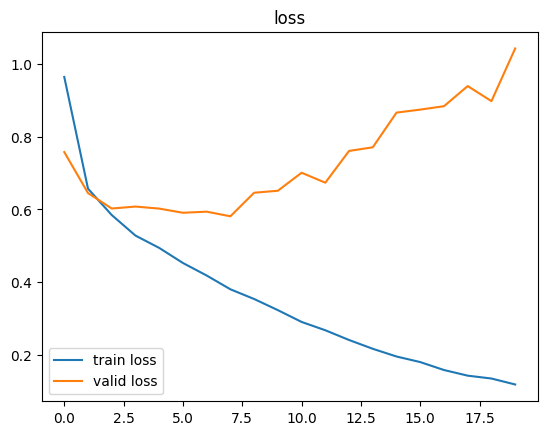

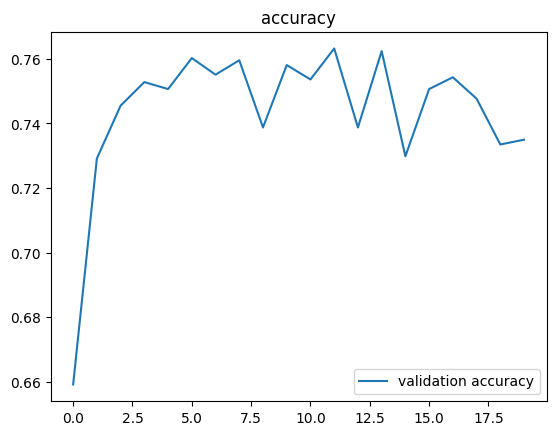

In [ ]:
plt.title("loss")
plt.plot(losses["train_losses"], label="train loss")
plt.plot(losses["valid_losses"], label="valid loss")
plt.legend()
plt.show()

plt.title("accuracy")
plt.plot(losses["valid_acc"], label="validation accuracy")
plt.legend()
plt.show()

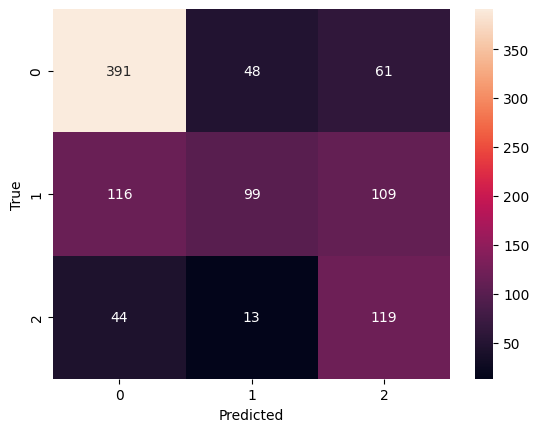

In [ ]:
# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
